# 🌈 Fractal Interpolation Functions & Neural Applications 🤖

This notebook explores the fascinating world of fractal interpolation using the Read-Bajraktarević (R-B) operator. We'll journey from simple linear base functions to more complex neural network bases, culminating in an exciting application: using fractal embeddings as positional encodings in a Transformer model! 🚀

## 🌟 Overview

Fractal interpolation generates complex, self-similar curves that pass through a given set of data points. Unlike traditional interpolation methods that produce smooth functions, fractal interpolation can capture intricate, "rough" details, making it ideal for modeling natural phenomena. The core idea relies on an Iterated Function System (IFS), where the fractal interpolant is the fixed point (attractor) of a special operator.

This notebook demonstrates:

- Linear Base Interpolation: A fundamental example using a simple linear function as the base interpolant. 📏

- Neural Base Interpolation: Replacing the linear base with a small neural network to learn a more flexible base interpolant. 🧠

- α-Fractal Positional Encoding: Applying the fractal interpolation concept to create positional embeddings for Transformer models, comparing its performance against traditional sinusoidal positional encoding on a text classification task. 📊

## 💡 Key Concepts

- Read-Bajraktarević (R-B) Operator: A contractive operator whose fixed point is the fractal interpolant. It defines how the function at a point depends on its value at a "scaled-down" version of that point. 🔄

- Base Function (β): A standard interpolant (e.g., linear, polynomial) that passes through the data points. The fractal interpolant is built upon this base.

- Scaling Factor (α): A crucial parameter (between 0 and 1) that controls the "fractalness" or "roughness" of the interpolant. A higher α generally leads to more fractal-like behavior. 🏔️

- Iterative Approximation: The fixed point of the R-B operator is found by repeatedly applying the operator to an initial guess (often the base function itself). 🔄

## 📈 1. Linear Base Interpolation

In this section, we start with a classic example: interpolating f(x) = sin(2πx) using a linear base function.

We define β(x) as a simple piecewise linear interpolant.

The inv_L function computes the inverse affine transformation for each subinterval, mapping a point x back to the original [a,b] domain.

The T operator is constructed, combining β, inv_L, and the scaling factor α.

We then iteratively apply T to β until φ (our fractal interpolant) converges.

The resulting plot clearly shows how the fractal interpolant passes through the original nodes while exhibiting more "roughness" compared to a pure linear interpolation. 📉✨

## 🧠 2. Neural Base Interpolation

Taking things up a notch, we replace the fixed linear base function with a small neural network (an MLP) that learns to interpolate the original data points.

A BaseNet (a simple nn.Sequential model) is defined and trained to minimize the MSE loss on the given nodes (nodes, f(nodes)). 🚀

Once trained, this BaseNet becomes our β for the R-B operator.

The T operator is then applied iteratively, similar to the linear case, but now leveraging the learned neural base.

This demonstrates the flexibility of using neural networks to define the base, potentially allowing for more complex or adaptive fractal interpolants. 🎨🤖

## 📊 3. α-Fractal vs. Sinusoidal Positional Encoding

This is where the fractal interpolation concept meets the cutting edge of deep learning! Positional encodings are vital in Transformers to infuse sequence order information. Traditionally, sinusoidal functions are used. Here, we explore using a fractal-based approach.

We load the ag_news text classification dataset. 📰

A basic tokenizer and vocabulary are created.

The FractalPE module is implemented, creating positional embeddings based on the R-B operator, with trainable "anchor" points.

A simple EncoderClassifier (a small Transformer encoder) is built, which can switch between traditional sinusoidal positional encoding and our new FractalPE.

Both models are trained for a single epoch (for a quick demo) and evaluated.

The output shows a comparison of training and test accuracies. You'll also see a visualization of some dimensions of the generated FractalPE vectors, highlighting their unique patterns! 📈🔥


## 🧪 Further Experiments

The world of fractal interpolation and its applications is vast! Here are some ideas for extending this notebook:

#### Hyperparameter Tuning:

- alpha (scaling factor): Experiment with values very close to 0 (smoother) or very close to 1 (more fractal/rough). What happens if alpha is negative or greater than 1? 🤯

- N (number of nodes): Increase or decrease the number of interpolation nodes. How does this affect the complexity and accuracy of the fractal interpolant? 🎯

- iters (iterations): Run the R-B operator for more iterations. Does the interpolant converge faster or slower for different alpha values? ⏳

#### Alternative Base Functions (β):

- Implement polynomial or spline bases for the first two sections. How do they compare to linear and neural bases? ✍️

- Design a more complex BaseNet for the neural base, perhaps with different activation functions or more layers. Does it lead to better convergence or different fractal patterns? 🕸️

#### Different Target Functions:

- Try interpolating f(x) with different characteristics: a sharp peak, a discontinuity, or even noisy real-world data. How robust is the fractal interpolant? 〰️

#### Fractal PE Enhancements:

- FractalPE Parameters: Fine-tune segments, alpha, and iters within the FractalPE class. Can you find a combination that significantly improves performance? 🛠️

- Deeper Models: Increase the number of layers (layers) in the EncoderClassifier. Does the advantage of Fractal PE (if any) persist or amplify in deeper networks? 🏗️

- Larger Datasets/Vocabs: Test on more complex NLP tasks or larger datasets to see if Fractal PE scales effectively. 📚

- Other PE Comparisons: Implement and compare against other modern positional encoding methods like Rotary Positional Embeddings (RoPE), T5 Relative Positional Bias, or ALiBi. ⚔️

- Visualization: Plot more dimensions of the FractalPE vectors. Try a heatmap or PCA/t-SNE visualization to understand their structure. 🌌

#### Computational Performance:

Analyze the speed and memory usage of the iterative R-B operator, especially with neural bases. Are there ways to optimize it? ⚡

How does the FractalPE layer's computation compare to sinusoidal or learned embeddings? ⏱️

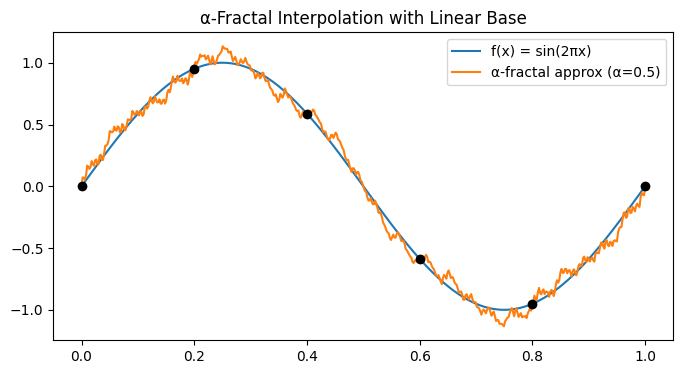

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Problem setup
f = lambda x: np.sin(2 * np.pi * x)
a, b = 0.0, 1.0
N = 5  # number of intervals
nodes = np.linspace(a, b, N + 1)


# 2. Linear base interpolant β
def beta(x):
    # find interval
    i = np.clip(np.searchsorted(nodes, x) - 1, 0, N - 1)
    x0, x1 = nodes[i], nodes[i + 1]
    y0, y1 = f(x0), f(x1)
    return y0 + (y1 - y0) * ((x - x0) / (x1 - x0))


# 3. Define Li⁻¹ on each subinterval
def inv_L(i, x):
    # since Li(x) = a_i x + b_i is simple affine mapping [a,b]→[x_{i-1},x_i]
    return ((x - nodes[i - 1]) / (nodes[i] - nodes[i - 1])) * (b - a) + a


# 4. Build the operator T
alpha = 0.5


def T(phi, xs):
    ys = np.zeros_like(xs)
    for idx, x in enumerate(xs):
        # locate i
        i = np.clip(np.searchsorted(nodes, x) - 1, 0, N - 1)
        x_prev = inv_L(i + 1, x)
        ys[idx] = alpha * phi(x_prev) + f(x) - alpha * beta(x_prev)
    return ys


# 5. Iterate to approximate fixed point
xs = np.linspace(a, b, 500)
phi_vals = beta(xs)  # initial guess = β
for _ in range(10):
    phi_vals = T(lambda x: np.interp(x, xs, phi_vals), xs)

# 6. Plot
plt.figure(figsize=(8, 4))
plt.plot(xs, f(xs), label="f(x) = sin(2πx)")
plt.plot(xs, phi_vals, label=f"α-fractal approx (α={alpha})")
plt.scatter(nodes, f(nodes), color="k", zorder=5)
plt.legend()
plt.title("α-Fractal Interpolation with Linear Base")
plt.show()

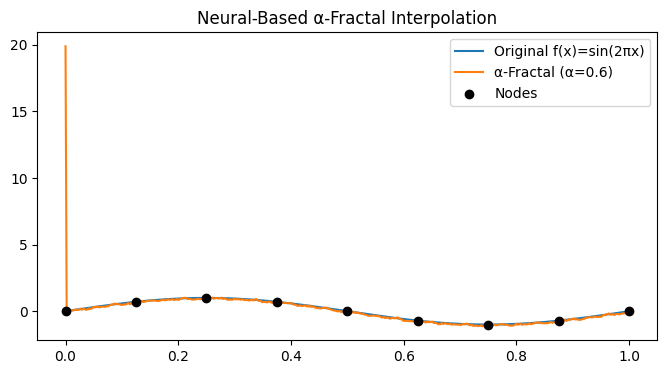

In [ ]:
# @title α-Fractal Interpolation with a Neural Base (PyTorch)
import torch
from torch import nn
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt

# 1. Problem setup
device = "cuda" if torch.cuda.is_available() else "cpu"
f = lambda x: np.sin(2 * np.pi * x)
a, b = 0.0, 1.0
N = 8
nodes = np.linspace(a, b, N + 1)


# 2. Define & train a small MLP β to interpolate f at the nodes
class BaseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32), nn.ReLU(), nn.Linear(32, 32), nn.ReLU(), nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)


# prepare training data (nodes)
x_train = torch.tensor(nodes, dtype=torch.float32, device=device).unsqueeze(1)
y_train = torch.tensor(f(nodes), dtype=torch.float32, device=device).unsqueeze(1)

beta = BaseNet().to(device)
opt = Adam(beta.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

# train for a quick fit
for epoch in range(500):
    opt.zero_grad()
    pred = beta(x_train)
    loss = loss_fn(pred, y_train)
    loss.backward()
    opt.step()
# β is now our learned interpolant

# 3. Read–Bajraktarević operator T using α
alpha = 0.6
xs = np.linspace(a, b, 500)
xs_t = torch.tensor(xs, dtype=torch.float32, device=device).unsqueeze(1)

# Precompute: interval widths & inverses
widths = nodes[1:] - nodes[:-1]


def inv_L(i, x):
    # map x back to [a,b]
    return (x - nodes[i]) / widths[i] * (b - a) + a


with torch.no_grad():
    # initial φ = β(xs)
    phi = beta(xs_t).squeeze().cpu().numpy()

for _ in range(15):
    phi_prev = phi.copy()
    phi_tensor = torch.tensor(phi_prev, dtype=torch.float32, device=device)
    new_vals = []
    for x in xs:
        # find interval i
        i = min(np.searchsorted(nodes, x) - 1, N - 1)
        x0 = inv_L(i, x)
        # network inputs must be normalized to [a,b]
        inp = torch.tensor([[x0]], device=device, dtype=torch.float32)
        b_val = beta(inp).item()
        phi_val = float(alpha * np.interp(x0, xs, phi_prev) + f(x) - alpha * b_val)
        new_vals.append(phi_val)
    phi = np.array(new_vals)

# 4. Plot
plt.figure(figsize=(8, 4))
plt.plot(xs, f(xs), label="Original f(x)=sin(2πx)")
plt.plot(xs, phi, label=f"α-Fractal (α={alpha})")
plt.scatter(nodes, f(nodes), color="k", zorder=5, label="Nodes")
plt.legend()
plt.title("Neural-Based α-Fractal Interpolation")
plt.show()

Using CUDA device: Tesla T4
Sinusoidal PE – train 68.5% | test 81.0%
Fractal    PE – train 72.8% | test 84.5%


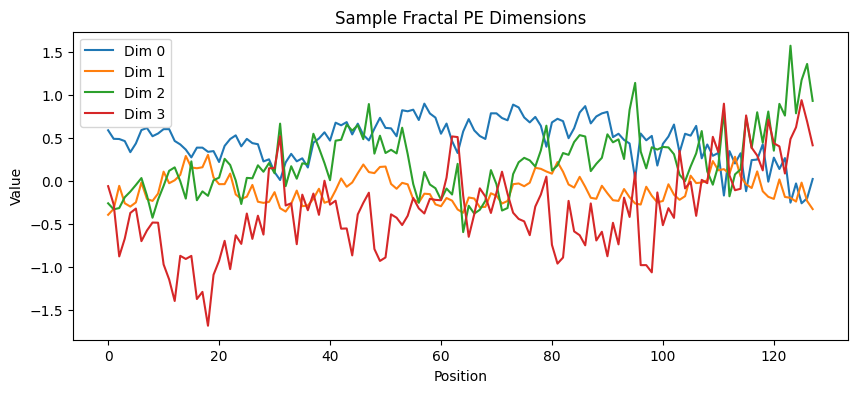

In [ ]:
# @title α‑Fractal vs. Sinusoidal Positional Encoding

# ────────────────── 0. Set‑up ──────────────────
!pip -q install -U datasets sentencepiece
import re
import torch
import torch.nn as nn
from datasets import load_dataset
from torch.utils.data import DataLoader
from collections import Counter

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(0)

# ────────────────── 1. Data ──────────────────
ds = load_dataset("ag_news")  # train/test splits, 4 labels (0‑3)

# simple "basic_english" tokenizer (whitespace + punctuation)
TOKEN_RE = re.compile(r"\w+|[^\w\s]")


def tokenize(txt: str):
    return TOKEN_RE.findall(txt.lower())


# build a tiny vocab (min_freq = 2 keeps the demo light)
counter = Counter(tok for ex in ds["train"]["text"] for tok in tokenize(ex))
PAD, UNK = "<pad>", "<unk>"
itos = [PAD, UNK] + [t for t, c in counter.items() if c >= 2]
stoi = {t: i for i, t in enumerate(itos)}


def numericalise(tokens):
    return [stoi.get(t, stoi[UNK]) for t in tokens]


MAX_LEN, PAD_IDX, NUM_CLASSES = 128, stoi[PAD], 4


def collate(batch):
    toks = [numericalise(tokenize(ex["text"]))[:MAX_LEN] for ex in batch]
    lbls = torch.tensor([ex["label"] for ex in batch])
    lens = [len(t) for t in toks]

    padded = torch.full((len(toks), MAX_LEN), PAD_IDX, dtype=torch.long)
    for i, t in enumerate(toks):
        padded[i, : lens[i]] = torch.tensor(t, dtype=torch.long)
    attn = padded != PAD_IDX
    return padded.to(device), attn.to(device), lbls.to(device)


train_loader = DataLoader(
    ds["train"],
    shuffle=True,
    batch_size=256,
    collate_fn=collate,
    num_workers=0,
    pin_memory=False,
)
test_loader = DataLoader(
    ds["test"], batch_size=512, collate_fn=collate, num_workers=0, pin_memory=False
)


# ────────────────── 2. Fractal PE ──────────────────
class FractalPE(nn.Module):
    """Uniform‑grid α‑fractal positional encoding (1‑D Read–Bajraktarević)."""

    def __init__(self, d_model, max_len, segments=8, alpha=0.9, iters=4):
        super().__init__()
        self.alpha, self.iters, self.seg = alpha, iters, segments
        self.anchors = nn.Parameter(torch.randn(segments + 1, d_model))

        t = torch.linspace(0, 1, max_len)
        seg_id = torch.floor(t * segments).long()
        lin_w = t * segments - seg_id.float()
        self.register_buffer("seg_id", seg_id)
        self.register_buffer("lin_w", lin_w.unsqueeze(-1))

    def forward(self, L):
        L = min(L, self.seg_id.shape[0])

        anchors_idx0 = self.seg_id[:L]
        anchors_idx1 = (self.seg_id[:L] + 1).clamp(max=self.seg)

        base = (1 - self.lin_w[:L]) * self.anchors[anchors_idx0] + self.lin_w[
            :L
        ] * self.anchors[anchors_idx1]

        phi = base
        for _ in range(self.iters):
            x_local = (torch.linspace(0, 1, L, device=phi.device) * self.seg) % 1
            idx = torch.round(x_local * (L - 1)).long()
            phi = self.alpha * phi[idx] + (1 - self.alpha) * base
        return phi


# ────────────────── 3. Encoder model ──────────────────
class EncoderClassifier(nn.Module):
    def __init__(self, d_model=128, nhead=4, layers=2, use_fractal=False):
        super().__init__()
        self.emb = nn.Embedding(len(itos), d_model, padding_idx=PAD_IDX)
        self.pos = (
            FractalPE(d_model, MAX_LEN)
            if use_fractal
            else nn.Embedding(MAX_LEN, d_model)
        )
        enc = nn.TransformerEncoderLayer(d_model, nhead, 4 * d_model, batch_first=True)
        self.encoder = nn.TransformerEncoder(enc, layers)
        self.fc = nn.Linear(d_model, NUM_CLASSES)
        self.use_fractal = use_fractal

    def forward(self, x, mask):
        h = self.emb(x)

        if self.use_fractal:
            pos_enc = self.pos(x.size(1))
        else:
            pos_enc = self.pos(torch.arange(x.size(1), device=x.device))

        h = h + pos_enc
        h = self.encoder(h, src_key_padding_mask=~mask)
        out = (h * mask.unsqueeze(-1)).sum(1) / mask.sum(1, keepdim=True)
        return self.fc(out)


# ────────────────── 4. Train / evaluate helpers ──────────────────
def epoch_loop(model, loader, opt=None):
    train = opt is not None
    model.train() if train else model.eval()
    tot = correct = 0
    for x, m, y in loader:
        if train:
            opt.zero_grad()
        logits = model(x, m)
        if train:
            nn.CrossEntropyLoss()(logits, y).backward()
            opt.step()
        pred = logits.argmax(1)
        tot += y.size(0)
        correct += (pred == y).sum().item()
    return correct / tot


def run(use_fractal):
    model = EncoderClassifier(use_fractal=use_fractal).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=3e-4)
    train_acc = epoch_loop(model, train_loader, opt)
    test_acc = epoch_loop(model, test_loader)
    return train_acc, test_acc


sin_train, sin_test = run(False)
fra_train, fra_test = run(True)

print(f"Sinusoidal PE – train {sin_train * 100:.1f}% | test {sin_test * 100:.1f}%")
print(f"Fractal    PE – train {fra_train * 100:.1f}% | test {fra_test * 100:.1f}%")

# print(f"Sinusoidal PE – train {sin_train*100:.1f}% | test {sin_test*100:.1f}%")
# print(f"Fractal    PE – train {fra_train*100:.1f}% | test {fra_test*100:.1f}%")
# Example visualization snippet (add after FractalPE definition)
import matplotlib.pyplot as plt

fractal_pe_module = FractalPE(
    d_model=128, max_len=128, segments=8, alpha=0.6, iters=4
).to(device)
pe_vectors = fractal_pe_module(128).detach().cpu().numpy()
#
plt.figure(figsize=(10, 4))
for i in range(4):  # Plot first 4 dimensions
    plt.plot(pe_vectors[:, i], label=f"Dim {i}")
plt.title("Sample Fractal PE Dimensions")
plt.xlabel("Position")
plt.ylabel("Value")
plt.legend()
plt.show()